In [1]:
# Note: This is a hack to allow importing from the parent directory
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent / "submodules/resnet-18-autoencoder/src"))

# Note: Ignore warnings, be brave (YoLo)
import warnings

warnings.filterwarnings("ignore")

In [2]:
import torch
import matplotlib.pyplot as plt

from utils import noop_collate
from models import ResNetAutoencoder
from data import CIFAR10GaussianSplatsDataset
from constants import CIFAR10_TRANSFORM, CIFAR10_INVERSE_TRANSFORM, TENSOR_TRANSFORM, PIL_TRANSFORM
from classes.resnet_autoencoder import AE as DefaultResNetAutoencoder

plt.style.use("../style/main.mpltstyle")

In [3]:
def capitalize(s):
    return s[0].upper() + s[1:]

def collect_samples_by_label(data, n_samples, test_loader, class_to_index, index_to_class):
    data = {k: [] for k in class_to_index.keys()}
    all_labels_filled = False  

    for batch in test_loader:
        if all_labels_filled:
            break  

        for image, index, splat in batch:
            label = index_to_class[index]
            if len(data[label]) < n_samples:
                data[label].append((image, splat))

            all_labels_filled = all(len(v) >= n_samples for v in data.values())
            if all_labels_filled:
                break  
            
    return data


def custom_forward(model, image):
    # TODO: Implement
    pass


def default_forward(model, image):
    return PIL_TRANSFORM(model(TENSOR_TRANSFORM(image))[0])

In [4]:
N_CLASSES = 10  
N_SAMPLES = 1
CUSTOM_MODEL = None # TODO: ResNetAutoencoder()
DEFAULT_MODEL = DefaultResNetAutoencoder("light")
DEFAULT_MODEL.load_state_dict(torch.load("../models/default_resnet_autoencoder.ckpt")["model_state_dict"])

test_dataset = CIFAR10GaussianSplatsDataset(
    root="../data/CIFAR10GS",
    test=True,
    init_type="grid",
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=noop_collate,
)

CLASS_TO_INDEX = test_dataset.class_to_index
INDEX_TO_CLASS = {v: k for k, v in CLASS_TO_INDEX.items()}
DATA = collect_samples_by_label(test_dataset, N_SAMPLES, test_loader, CLASS_TO_INDEX, INDEX_TO_CLASS)
CUSTOM_RESULTS = {k: [] for k in CLASS_TO_INDEX.keys()}
DEFAULT_RESULTS = {k: [] for k in CLASS_TO_INDEX.keys()}

In [5]:
for label, samples in DATA.items():
    for image, splat in samples:
        if CUSTOM_MODEL:
            CUSTOM_RESULTS[label].append(custom_forward(CUSTOM_MODEL, image))
        if DEFAULT_MODEL:
            DEFAULT_RESULTS[label].append(default_forward(DEFAULT_MODEL, image))

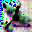

In [6]:
DEFAULT_RESULTS["airplane"][0]

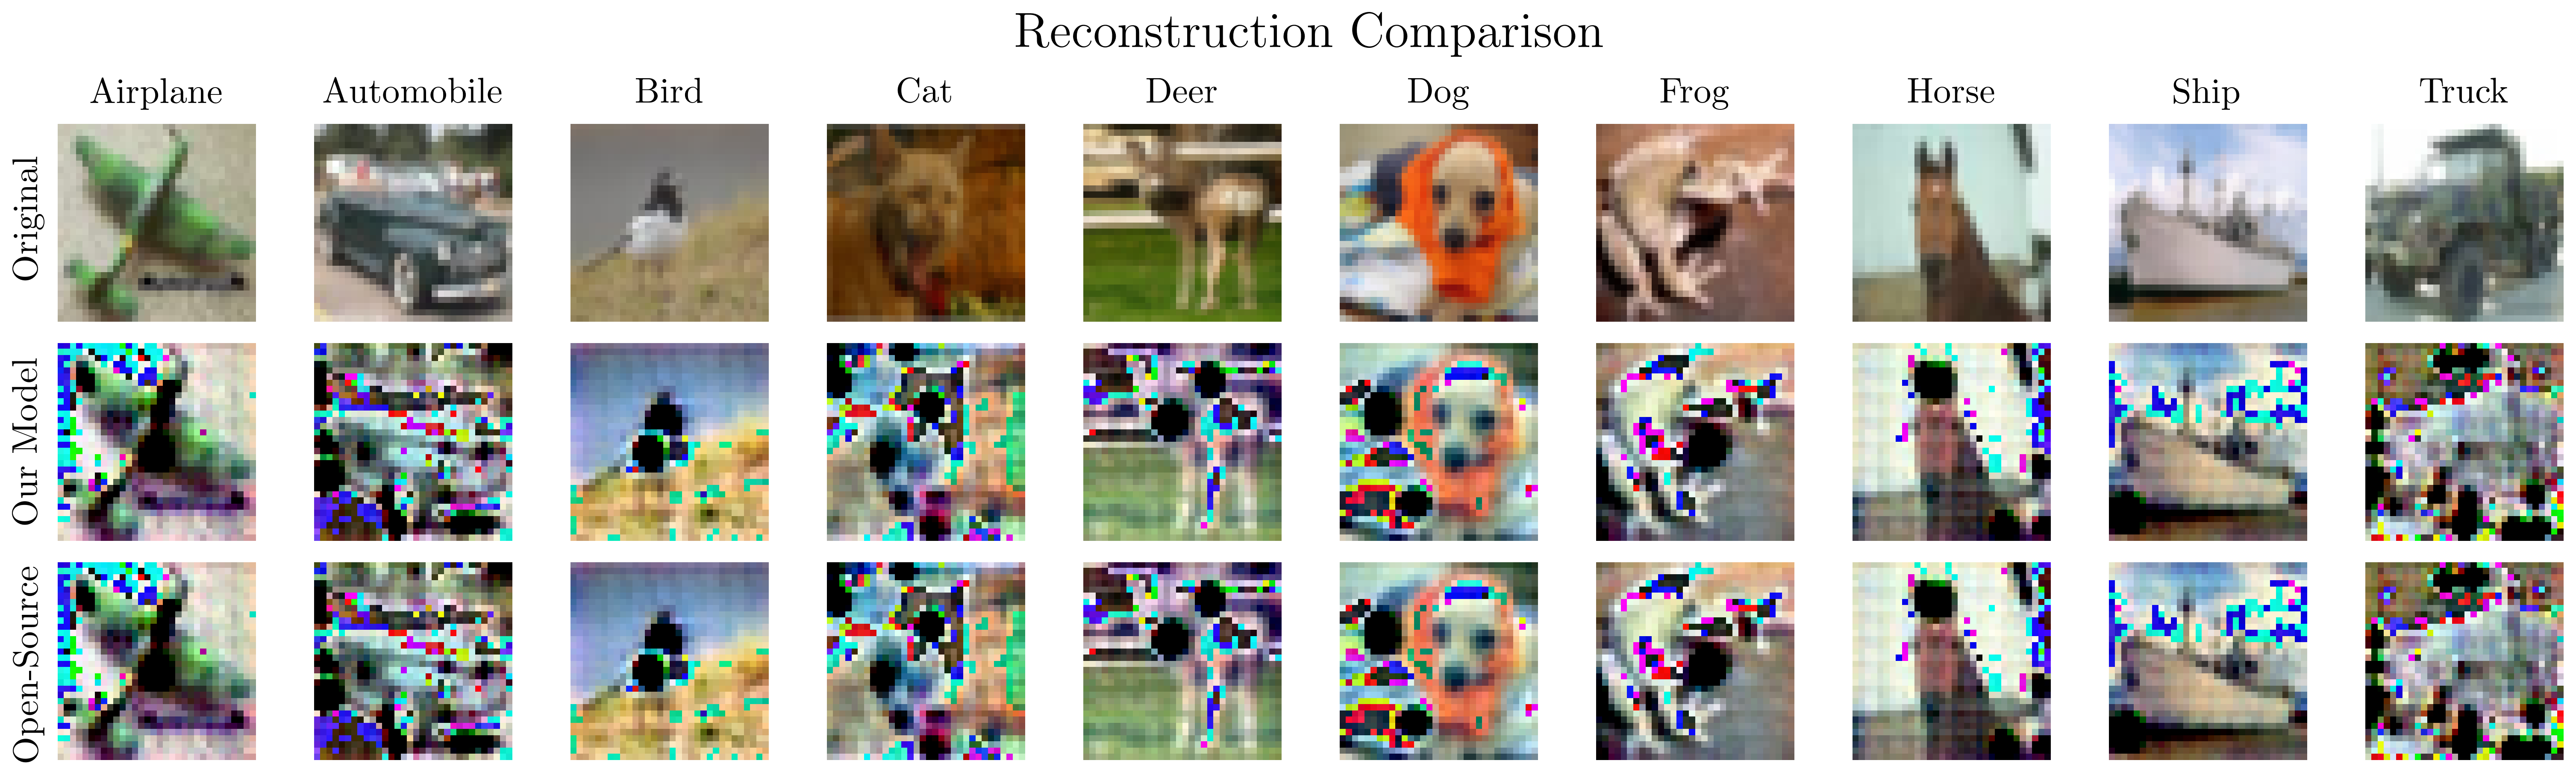

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    3, N_CLASSES, figsize=(N_CLASSES, N_SAMPLES * 3), constrained_layout=True
)
fig.suptitle("Reconstruction Comparison", fontsize=14, fontweight="bold")

for col, (label, samples) in enumerate(DATA.items()):
    for row, (image, _) in enumerate(samples):
        axes[0, col].imshow(image)
        axes[0, col].axis("off")

        axes[1, col].axis("off")
        if CUSTOM_MODEL:
            axes[1, col].imshow(CUSTOM_RESULTS[label][row])

        axes[2, col].axis("off")
        if DEFAULT_MODEL:
            axes[1, col].imshow(DEFAULT_RESULTS[label][row])
            axes[2, col].imshow(DEFAULT_RESULTS[label][row])

    axes[0, col].set_title(capitalize(label), fontsize=10, fontweight="bold", rotation=0)

row_titles = ["Original", "Our Model", "Open-Source"]
for i, title in enumerate(row_titles):
    fig.text(
        0, 1 - (i * 0.29) - 0.28,
        title, fontsize=10, fontweight="bold",
        va="center", ha="center", rotation=90
    )

plt.savefig("../images/reconstruction_comparison.png", dpi=300)

